In [22]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.utils import plot_model

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

In [2]:
tukey = pd.read_pickle("data/tukey_estimates.pkl")

In [3]:
display(tukey)

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,GLE FP Equity,ITX SQ Equity,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,ABI BB Equity,DTE GY Equity
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,172.238263,16.736604,99.034488,55.665822,25.358872,1.824092,75.880213,116.825089,3.181227,19.752234,...,41.521580,23.759661,125.902304,8.765737,66.782484,61.710266,10.092679,17.514403,75.953076,12.211867
2014-01-08,172.102293,16.735788,99.043180,56.728987,25.510426,1.862744,75.880213,115.552453,3.207795,20.042696,...,42.740375,23.762729,125.562759,9.063023,65.853610,61.917861,10.234399,17.523683,76.493208,12.234477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,124.836483,12.606887,61.540621,40.078547,29.350772,1.965261,75.789259,252.058477,5.126762,18.855035,...,28.432547,23.298261,201.986632,4.670203,137.961633,87.781997,9.655289,13.825773,60.383072,15.147594
2018-12-24,123.468435,12.504685,61.368677,39.537086,28.972531,1.934419,75.371460,250.655979,5.161952,18.793871,...,28.076481,22.764505,200.887660,4.638877,134.468998,87.359661,9.452786,13.808154,59.715154,15.089206
2018-12-27,123.457018,12.334064,61.260000,39.062524,28.691903,1.911204,74.550430,248.904726,5.162891,18.708701,...,27.723237,22.461907,198.926965,4.593145,132.811798,86.487926,9.339000,13.790183,58.822954,15.028209
2018-12-28,121.125796,12.272935,60.788612,39.055638,28.653773,1.911204,74.319489,249.657146,5.116054,18.781056,...,27.682620,22.357239,197.977005,4.590392,133.051222,86.399312,9.339302,13.765333,58.161534,14.875310


# Very stupid test completely wrong

In [4]:
X = tukey.iloc[3:, 0]

In [5]:
def df_to_X_y(df, window_size=1):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i: i+window_size]]
        X.append(row)
        y.append(df_as_np[i+window_size])
    return np.array(X), np.array(y)

In [6]:
WINDOW_SIZE = 30
X, y = df_to_X_y(X, window_size=WINDOW_SIZE)
print(X.shape)
print(y.shape)

(1239, 30, 1)
(1239,)


In [7]:
train_size = 0.8
X_train = X[:int(train_size*len(X))]
y_train = y[:int(train_size*len(X))]
X_test = X[int(train_size*len(X)):]
y_test = y[int(train_size*len(X)):]

In [8]:
model = Sequential()
model.add(
    InputLayer(
        (WINDOW_SIZE, 1)
    )
)
model.add(
    LSTM(
        64
    )
)
model.add(
    Dense(
        8,
        "relu"
    )
)
model.add(
    Dense(
        1,
        "linear"
    )
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(
    loss="MSE",
    optimizer="adam",
)

In [10]:
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100

31/31 [==============================] - 9s 35ms/step - loss: 18894.9062
Epoch 2/100
31/31 [==============================] - 1s 34ms/step - loss: 18557.8887
Epoch 3/100
31/31 [==============================] - 1s 33ms/step - loss: 17953.4160
Epoch 4/100
31/31 [==============================] - 1s 34ms/step - loss: 16979.5723
Epoch 5/100
31/31 [==============================] - 1s 32ms/step - loss: 15849.0049
Epoch 6/100
31/31 [==============================] - 1s 34ms/step - loss: 14653.7627
Epoch 7/100
31/31 [==============================] - 1s 34ms/step - loss: 13453.7871
Epoch 8/100
31/31 [==============================] - 1s 34ms/step - loss: 12207.8838
Epoch 9/100
31/31 [==============================] - 1s 33ms/step - loss: 10930.4355
Epoch 10/100
31/31 [==============================] - 1s 31ms/step - loss: 9638.0840
Epoch 11/100
31/31 [==============================] - 1s 27ms/step - loss: 8379.2715
Epoch 12/100
31/31 [==============================] - 1s 33ms/st

In [11]:
train_predictions = model.predict(X_train).flatten()

31/31 [==============================] - 2s 15ms/step


In [12]:
train_predictions

array([173.26167 , 174.21777 , 173.5364  , 172.45016 , 172.3276  ,
       171.03317 , 164.28073 , 158.7528  , 162.23868 , 163.90283 ,
       161.87933 , 159.64108 , 159.30042 , 159.55054 , 159.6984  ,
       157.11719 , 155.48698 , 154.79308 , 154.06984 , 154.21758 ,
       154.14697 , 154.11104 , 155.3249  , 155.76553 , 155.1166  ,
       154.33847 , 154.83961 , 155.5736  , 156.97978 , 159.69713 ,
       161.12573 , 162.58708 , 163.87817 , 164.33554 , 164.40424 ,
       163.56026 , 163.2678  , 164.48434 , 167.1384  , 168.5182  ,
       167.45999 , 164.63025 , 164.92717 , 166.08707 , 167.8935  ,
       169.11115 , 168.3241  , 168.06793 , 167.08276 , 166.06662 ,
       165.95438 , 165.57977 , 164.20206 , 163.42496 , 162.26205 ,
       163.05614 , 163.28258 , 164.75021 , 164.83002 , 163.67685 ,
       162.44156 , 161.08553 , 162.00653 , 162.84242 , 163.57779 ,
       163.82329 , 164.09488 , 165.81433 , 167.09    , 168.051   ,
       167.52199 , 167.2479  , 167.68143 , 168.05713 , 167.790

In [13]:
results = pd.DataFrame({
    "train_predictions": train_predictions,
    "actual": y_train
})

In [14]:
results

,train_predictions,actual
0,173.261673,174.005111
1,174.217773,173.839808
2,173.536407,173.226575
3,172.450165,172.928465
4,172.327606,171.780423
...,...,...
986,142.783020,143.905876
987,144.114243,145.779154
988,147.442123,148.627237
989,150.820892,151.702441


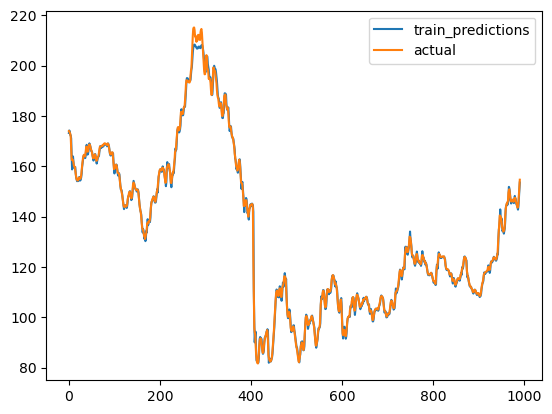

In [15]:
results.plot()
plt.plot();

## Forecast

In [16]:
def forecast(starting_data, window_size=5, stop_after=365):
    forecast = [i for i in starting_data[-window_size:]]
    for i in range(stop_after):
        p = np.array(forecast[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(p, verbose=0)
        forecast.append(prediction[0][0])
    return np.array(forecast[window_size:])

In [17]:
tukey_test = tukey.iloc[-252:, 0].to_numpy()
tukey_start = tukey.iloc[3:-252, 0].to_numpy()

In [18]:
forecasts = forecast(tukey_start, window_size=10, stop_after=252)

In [19]:
forecast_results = pd.DataFrame({
    "forecast": forecasts,
    "actual": tukey_test
})

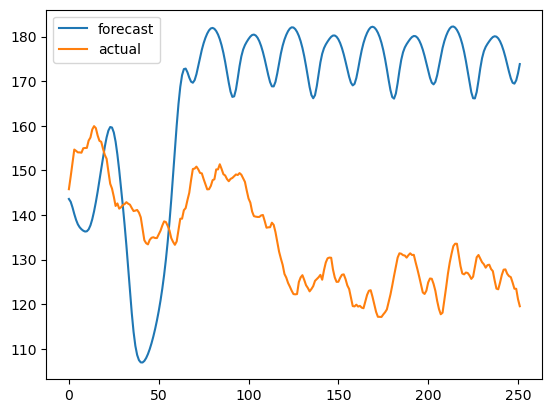

In [20]:
forecast_results.plot()
plt.show()